In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Hyperband
from tensorflow.keras.datasets import mnist

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1] range

# Flatten images to a 1D vector
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Define the MLP model with Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(28*28,)))

    # Tune the number of hidden layers and units per layer
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                               activation=hp.Choice("activation", ["relu", "tanh"])))
        
        # Optionally add dropout
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=hp.Float("dropout_rate", 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(10, activation="softmax"))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Set up Keras Tuner with Hyperband
tuner = Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="kt_hyperband",
    project_name="mnist_mlp"
)

# Early stopping callback to stop training if no improvement
early_stop = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

# Run the hyperparameter search
tuner.search(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stop])

# Get the best model and evaluate it on the test set
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print("Test accuracy: {:.2f}%".format(test_acc * 100))


Trial 30 Complete [00h 01m 01s]
val_accuracy: 0.9375

Best val_accuracy So Far: 0.9800000190734863
Total elapsed time: 00h 11m 05s
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9735 - loss: 0.1023
Test accuracy: 97.82%


In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1] range

# Flatten images to a 1D vector
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Define the MLP model with Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(28*28,)))

    # Tune the number of hidden layers and units per layer
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                               activation="relu"))

    # Output layer
    model.add(layers.Dense(10, activation="softmax"))

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Set up Keras Tuner with Random Search
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,  # You can increase this number to explore more configurations
    executions_per_trial=2,  # Average results over 2 executions per trial
    directory="kt_random_search",
    project_name="mnist_mlp"
)

# Early stopping callback to stop training if no improvement
early_stop = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

# Run the hyperparameter search, including tuning batch size
tuner.search(
    x_train, 
    y_train, 
    epochs=20, 
    validation_split=0.2, 
    callbacks=[early_stop],
    batch_size=32  # Optional: Set a fixed batch size here or add it as a hyperparameter in the `build_model` function
)

# Get the best model and evaluate it on the test set
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print("Test accuracy: {:.2f}%".format(test_acc * 100))

Trial 5 Complete [00h 01m 14s]
val_accuracy: 0.9728333353996277

Best val_accuracy So Far: 0.9759583473205566
Total elapsed time: 00h 05m 42s
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9763 - loss: 0.0815
Test accuracy: 97.87%


In [ ]:
# Get the best hyperparameters

In [17]:

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for hp in best_hyperparameters.values:
    print(f"{hp}: {best_hyperparameters.get(hp)}")


Best Hyperparameters:
num_layers: 2
units_0: 128
learning_rate: 0.0003886808222604436
units_1: 64


In [19]:
# Evaluate the best model
import time

start_time = time.time()
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
end_time = time.time()
training_time = end_time - start_time

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Training Time: {training_time:.2f} seconds")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.9761 - loss: 0.0822
Test Accuracy: 0.9787
Test Loss: 0.0743
Training Time: 0.34 seconds


In [21]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"Best Trial Metrics: {best_trial.metrics}")


Best Trial Metrics: <keras_tuner.src.engine.metrics_tracking.MetricsTracker object at 0x000001C9A741CA70>


In [ ]:
#Learning curves 

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9973 - loss: 0.0098 - val_accuracy: 0.9752 - val_loss: 0.1143
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9984 - loss: 0.0066 - val_accuracy: 0.9746 - val_loss: 0.1134
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 0.9758 - val_loss: 0.1135
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.9728 - val_loss: 0.1280
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9989 - loss: 0.0050 - val_accuracy: 0.9765 - val_loss: 0.1232
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9992 - loss: 0.0043 - val_accuracy: 0.9795 - val_loss: 0.1099
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9742 - val_loss: 0.1365
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9980 - loss: 0.0068 - 

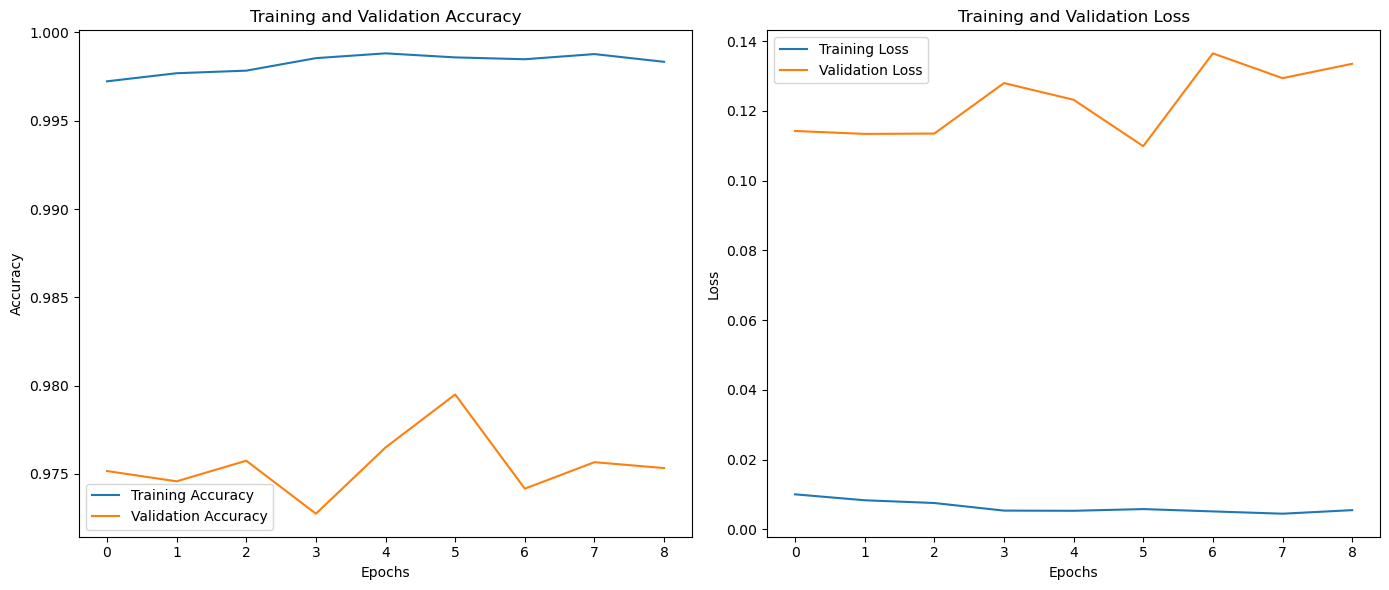

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.9725 - loss: 0.1359
Test accuracy: 97.62%


In [32]:
import matplotlib.pyplot as plt
import numpy as np
history = best_model.fit(
    x_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot learning curves for accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the final best model on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")